In [45]:
from utils import *

# Carregar os dados
df = pd.read_csv('./us_change.csv')
df = (df
    .assign(date=pd.PeriodIndex(df.Quarter.str.replace(' ', ''), freq='Q').to_timestamp())
    .set_index('date'))
df = df.asfreq('QS-OCT')

# Seleção da variável target
target = 'Consumption' 

# Dividir os dados em treino e teste
train_size = int(len(df) * 0.75)  # 75% treino, 25% teste
train, test = df.iloc[:train_size], df.iloc[train_size:]


In [46]:
# Modelo Baseline (Naïve)
baseline_preds = np.repeat(train[target].iloc[-1], len(test))  # Último valor como previsão

# Modelo de Suavização Exponencial Simples
model_exp = sm.tsa.SimpleExpSmoothing(train[target]).fit() # Modelo do conjunto de treino
exp_preds = model_exp.forecast(len(test))  # Previsões para o conjunto de teste

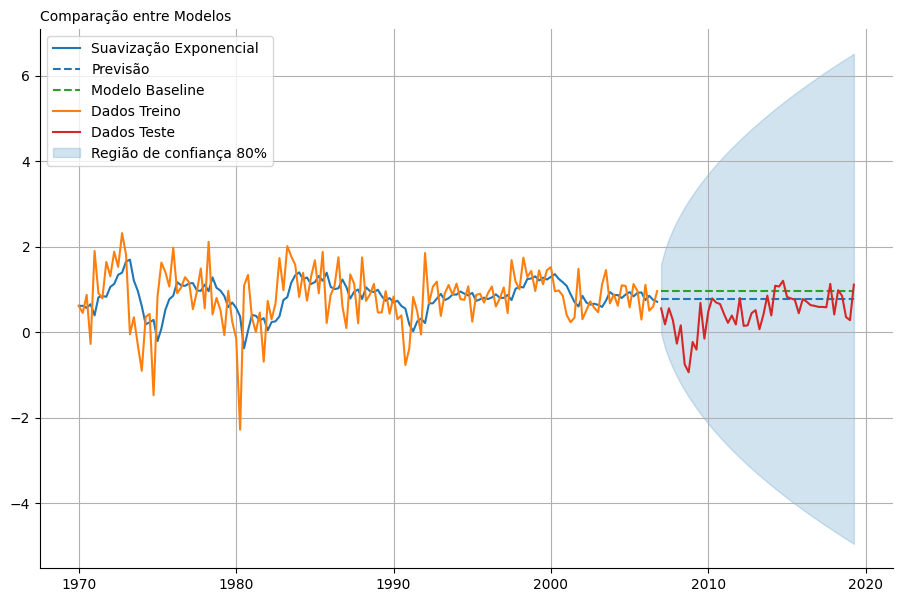

In [47]:
# Visualizar os resultados
plt.figure(figsize=(11, 7))
plt.plot(model_exp.fittedvalues, label="Suavização Exponencial")
plt.plot(test.index, exp_preds, label="Previsão", linestyle="--", color='C0')
plt.plot(test.index, baseline_preds, label="Modelo Baseline", linestyle="--", color='C2')
plt.plot(train[target], label="Dados Treino", color='C1')
plt.plot(test[target], label="Dados Teste", color='C3')
fcast = exp_preds
sigma = (df[target] - model_exp.fittedvalues._append(fcast)).std()
dy = sigma * np.sqrt(1+np.arange(len(fcast)))
s = errorscale(80)
plt.fill_between(fcast.index, fcast - s*dy, fcast + s*dy, color='C0', alpha=.2, label="Região de confiança 80%")
plt.title("Comparação entre Modelos")
plt.legend()
plt.grid()

In [67]:
# Comparar as previsões
def pred_summary(y, pred, str):
    summary = {
        "RMSE": np.sqrt(np.mean((pred-y)**2)),
        "MAE": np.mean(np.abs(pred-y)),
        "No. Observations": len(pred)
    }
    return pd.DataFrame(summary, index=[str])

def compare(y, preds, strs):
    comp = pred_summary(y, preds[0], strs[0])
    for i in range(1,len(preds)):
        comp = comp._append(pred_summary(y, preds[i], strs[i]))
    return comp

preds = [baseline_preds, exp_preds]
strs = ["Baseline", "Suav Exp"]
compare(test[target], preds, strs)

,RMSE,MAE,No. Observations
Baseline,0.670611,0.531336,50
Suav Exp,0.550465,0.403867,50


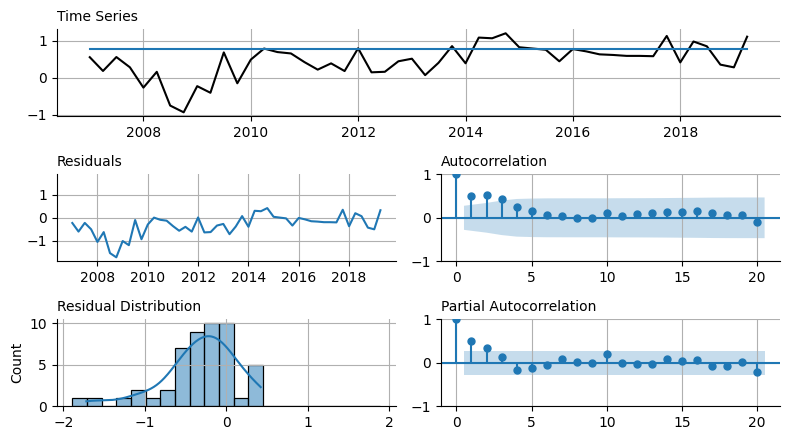

In [31]:
# Plotar resíduos
def plot_tsresiduals(Y, y):
    """Plot timeseries residuals for ground truth Y and estimate y."""
    fig = plt.figure()
    gs = plt.GridSpec(3, 2, figure=fig)
    ts_ax = fig.add_subplot(gs[0,:])
    axs = np.array([ts_ax] + [fig.add_subplot(gs[i, j]) for j in (0, 1) for i in (1, 2)])
    ax, rax, hax, acfax, pacfax = axs
    mask = ~(np.isnan(Y) | np.isnan(y))
    Y, y = Y[mask], y[mask]
    dy = Y - y
    ax.plot(Y, color='k')
    ax.plot(y)
    ax.set(title='Time Series')
    lim = 1.1 * max(-dy.min(), dy.max())
    lim = -lim, lim
    rax.plot(dy)
    rax.set(ylim=lim, title='Residuals')
    sns.histplot(dy, bins=np.linspace(lim[0], lim[1], 22), kde=True, ax=hax)
    hax.set(title='Residual Distribution')
    sm.graphics.tsa.plot_acf(dy, lags=min(len(dy) // 2 - 1, 20), ax=acfax)
    sm.graphics.tsa.plot_pacf(dy, lags=min(len(dy) // 2 - 1, 20), ax=pacfax)
    for a in axs.ravel():
        a.grid()
    plt.tight_layout()
    #return fig, axs

plot_tsresiduals(test[target], exp_preds)

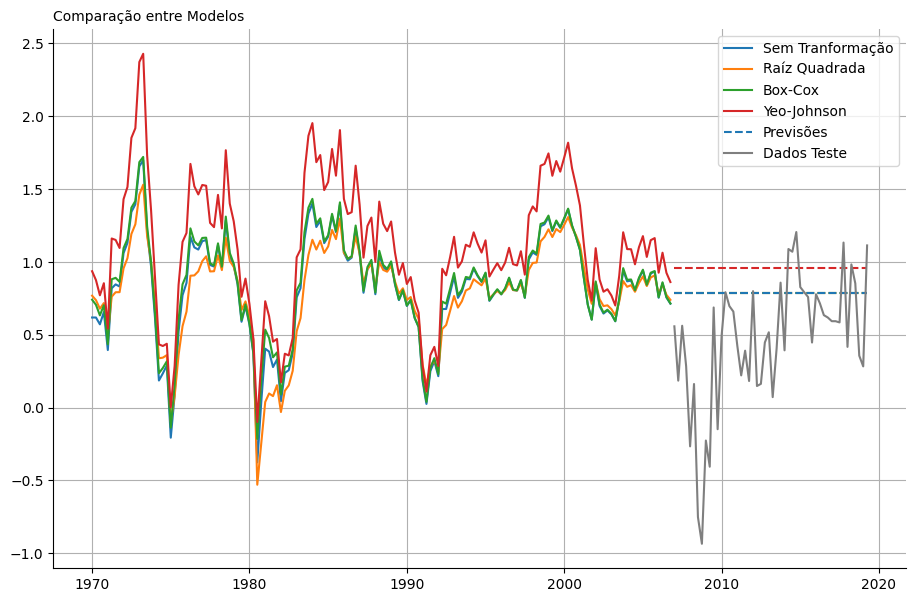

In [76]:

# Transformações
offset = abs(train[target].min()) + 1e-5  # Garantir valores positivos
train_adj = train[target] + offset
plt.figure(figsize=(11, 7))
plt.plot(model_exp.fittedvalues, label="Sem Tranformação")

# Raiz Quadrada
train_sqrt = np.sqrt(train_adj)  # Aplica a transformação raiz quadrada
model_sqrt = sm.tsa.ExponentialSmoothing(train_sqrt).fit()
sqrt_train = np.square(model_sqrt.fittedvalues) - offset
sqrt_preds = np.square(model_sqrt.forecast(len(test))) - offset
plt.plot(sqrt_train, label="Raíz Quadrada", color='C1')
plt.plot(test.index, sqrt_preds, color='C1', linestyle="--")

# Box-Cox
model_box = sm.tsa.ExponentialSmoothing(train_adj, use_boxcox=True).fit()
box_train = model_box.fittedvalues - offset
box_preds = model_box.forecast(len(test)) - offset
plt.plot(box_train, label="Box-Cox", color='C2')
plt.plot(test.index, box_preds, color='C2', linestyle="--")

# Yeo-Johnson
train_yj, lambda_yj = stats.yeojohnson(train[target])  # Aplica a transformação Yeo-Johnson
model_yj = sm.tsa.ExponentialSmoothing(train_yj).fit()
yj_train = model_yj.fittedvalues
yj_preds = model_yj.forecast(len(test))
plt.plot(train.index, yj_train, label='Yeo-Johnson', color='C3')
plt.plot(test.index, yj_preds, color='C3', linestyle="--")


plt.plot(test.index, exp_preds, label="Previsões", linestyle="--", color='C0')
plt.plot(test[target], label="Dados Teste", color='C7')
plt.title("Comparação entre Modelos")
plt.legend()
plt.grid()

In [68]:
preds = [exp_preds, sqrt_preds, box_preds, yj_preds]
strs = ["Sem Transf", "Raíz Quadrada", "Box-Cox", 'Yeo-Johnson']
compare(test[target], preds, strs)

,RMSE,MAE,No. Observations
Sem Transf,0.550465,0.403867,50
Raíz Quadrada,0.550756,0.404128,50
Box-Cox,0.552619,0.405790,50
Yeo-Johnson,0.665426,0.526020,50


In [69]:
preds = [model_exp.fittedvalues, sqrt_train, box_train, yj_train]
compare(train[target], preds, strs)

,RMSE,MAE,No. Observations
Sem Transf,0.662001,0.490333,148
Raíz Quadrada,0.682745,0.509322,148
Box-Cox,0.656086,0.486687,148
Yeo-Johnson,0.742098,0.560271,148


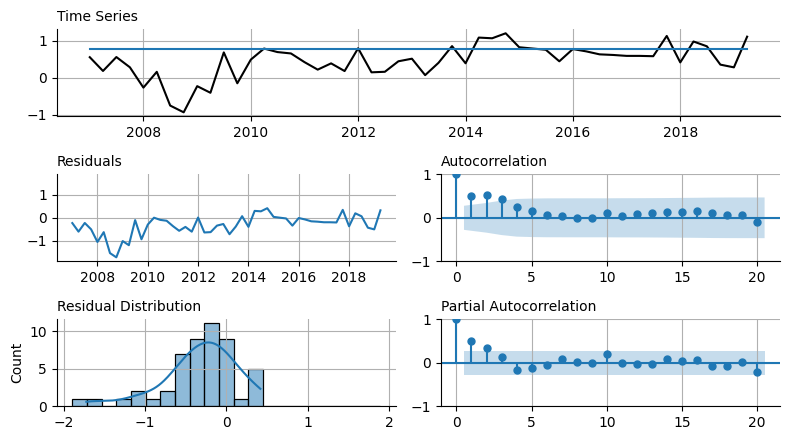

In [35]:
plot_tsresiduals(test[target], box_preds)

In [70]:
# Modelo com Tendência (Holt)
model_trend = sm.tsa.ExponentialSmoothing(train_adj, use_boxcox=True, trend='add').fit()
trend_train = model_trend.fittedvalues - offset
trend_preds = model_trend.forecast(len(test)) - offset

compare(test[target],[box_preds, trend_preds],["Sem Tendência", "Com Tendência"])

,RMSE,MAE,No. Observations
Sem Tendência,0.552619,0.405790,50
Com Tendência,0.556016,0.409538,50


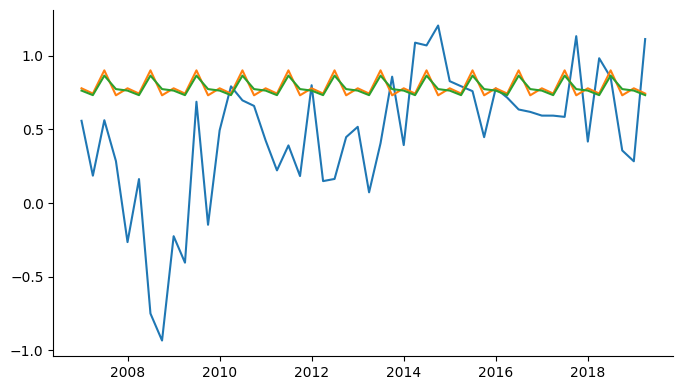

In [ ]:
# Holt Winters (sazonalidade)

model_s1 = sm.tsa.ExponentialSmoothing(train_adj, use_boxcox=True, seasonal='add', seasonal_periods=4).fit()
s1_train = model_s1.fittedvalues - offset
s1_preds = model_s1.forecast(len(test)) - offset
model_s2 = sm.tsa.ExponentialSmoothing(train_adj, use_boxcox=True, seasonal='mul', seasonal_periods=4).fit()
s2_train = model_s2.fittedvalues - offset
s2_preds = model_s2.forecast(len(test)) - offset

plt.plot(test[target])
plt.plot(s1_preds)
plt.plot(s2_preds)

In [71]:
model_exp.summary()

Dep. Variable:,Consumption,No. Observations:,148
Model:,SimpleExpSmoothing,SSE,64.860
Optimized:,True,AIC,-118.097
Trend:,None,BIC,-112.102
Seasonal:,None,AICC,-117.817
Seasonal Periods:,None,Date:,"Sat, 23 Nov 2024"
Box-Cox:,False,Time:,18:25:21
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.2814303,alpha,True
initial_level,0.6185664,l.0,False


In [72]:
model_box.summary()

Dep. Variable:,Consumption,No. Observations:,148
Model:,ExponentialSmoothing,SSE,63.707
Optimized:,True,AIC,-120.753
Trend:,None,BIC,-114.759
Seasonal:,None,AICC,-120.473
Seasonal Periods:,None,Date:,"Sat, 23 Nov 2024"
Box-Cox:,True,Time:,18:25:35
Box-Cox Coeff.:,1.34670,,
,coeff,code,optimized
smoothing_level,0.2883587,alpha,True
initial_level,2.5451988,l.0,True


                  0         1         2         3         4         5   \
2007-01-01  0.144653  0.693248  0.486202  1.246496  0.794601  0.962551   
2007-04-01  0.845491 -0.322269  1.627806  1.050844 -0.638825  0.989592   
2007-07-01  0.368446  0.390211  2.041826  1.715017  0.687705  1.509914   
2007-10-01  0.516430  0.453303  1.066093  1.155912  1.130167  1.901682   
2008-01-01  0.374304  0.617603  1.080133  2.740108 -0.328365  2.411825   
2008-04-01  0.066696  0.887045  2.241792  1.112964  0.638596  1.224684   
2008-07-01  1.234883  2.118932 -0.389222 -0.107616  1.611290  1.704428   
2008-10-01  1.558602  1.366245  0.750468  1.100297  1.248786  0.774799   
2009-01-01  1.406080  1.611302  2.017912  0.733590  0.283710 -0.498288   
2009-04-01  0.735835  2.334511  1.151005  2.061345  0.293944  0.251953   
2009-07-01 -0.005438  0.825868  0.699845  1.514570  0.982392  0.165634   
2009-10-01  0.400415  1.112930  2.911009  2.054374  0.736803  0.901440   
2010-01-01  0.556980  1.327143  3.7113

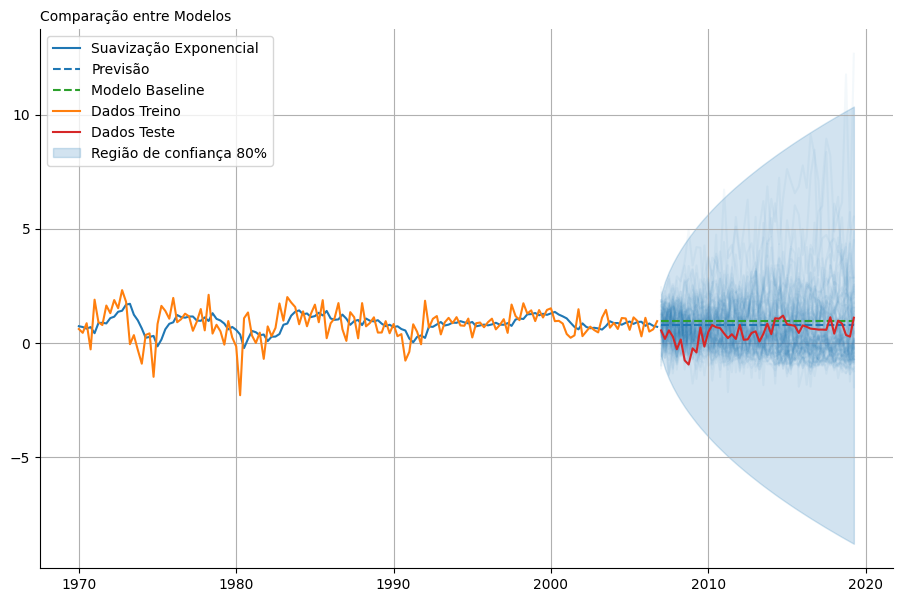

In [ ]:
# Visualizar simulações
simulations = model_box.simulate(len(test), repetitions=99, error="mul") - offset

plt.figure(figsize=(11, 7))
plt.plot(box_train, label="Suavização Exponencial")
plt.plot(test.index, box_preds, label="Previsão", linestyle="--", color='C0')
plt.plot(test.index, simulations, alpha=0.05, color='C0')
plt.plot(test.index, baseline_preds, label="Modelo Baseline", linestyle="--", color='C2')
plt.plot(train[target], label="Dados Treino", color='C1')
plt.plot(test[target], label="Dados Teste", color='C3')
m = max(abs(min(test[target]), max(test[target])))
count = 0
for i in range(len(test)):
    if(i > -m or i < m):
        count += 1
percent = 100 * count/len(test)
plt.fill_between(test.index, -m, m, color='C0', alpha=.2, label="Região de confiança"+str(percent)+"%")
plt.title("Comparação entre Modelos")
plt.legend()
plt.grid()